  This notebook shows an example of neural networks applied to time series classification using Tensorflow. The task here is to classify 6 different types of activities (walking, walking upstairs, walking downstairs, sitting, standing, laying) based on x, y and z accelerometer signals. We extract features from x, y and z signals (statistical features, geometrical features, frequency domain features...) and feed them into a 2-layer Neural Network with softmax activation. We add L2 regularization to prevent overfitting.

## Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import preprocessing
import plot_confusion_matrix as pcm
import matplotlib.pylab as plt
%matplotlib

Using matplotlib backend: MacOSX


## Loading data

We load the raw accelerometer signals of the 3 available axis (x, y and z). Each sample of the data set is a 2.56s window of an activity being performed recorded at a 50Hz rate which makes 128 readings per sample per axis.

In [2]:
os.chdir('data')
# Raw signals
# X axis
X_train_x_raw = np.loadtxt('X_x_train.txt')
X_test_x_raw = np.loadtxt('X_x_test.txt')
# Y axis
X_train_y_raw = np.loadtxt('X_y_train.txt')
X_test_y_raw = np.loadtxt('X_y_test.txt')
# Z axis
X_train_z_raw = np.loadtxt('X_z_train.txt')
X_test_z_raw = np.loadtxt('X_z_test.txt')

print("X_train_x_raw shape : {}".format(X_train_x_raw.shape))
print("X_test_x_raw shape : {}".format(X_test_x_raw.shape))
print("X_train_y_raw shape : {}".format(X_train_y_raw.shape))
print("X_test_y_raw shape : {}".format(X_test_y_raw.shape))
print("X_train_z_raw shape : {}".format(X_train_z_raw.shape))
print("X_test_z_raw shape : {}".format(X_test_z_raw.shape))

X_train_x_raw shape : (7352, 128)
X_test_x_raw shape : (2947, 128)
X_train_y_raw shape : (7352, 128)
X_test_y_raw shape : (2947, 128)
X_train_z_raw shape : (7352, 128)
X_test_z_raw shape : (2947, 128)


## Feature extraction helper functions

As explained at the beginning of this notebook, we are not going to use the raw signals as input for our model but we are going to extract features from the signals. The following functions help us build the feature vectors out of the raw signals we have loaded above.
These functions help us extract statistical and geometrical features from raw signals and jerk signals (acceleration first derivative), frequency domain features from raw signals and jerk signals
For each sample we extract the following features:
  - **x,y and z raw signals** : mean, max, min, standard deviation, skewness, kurtosis, interquartile range, median absolute deviation, area under curve, area under squared curve
  - **x,y and z jerk signals (first derivative)** : mean, max, min, standard deviation, skewness, kurtosis, interquartile range, median absolute deviation, area under curve, area under squared curve
  - **x,y and z raw signals Discrete Fourrier Transform**: mean, max, min, standard deviation, skewness, kurtosis, interquartile range, median absolute deviation, area under curve, area under squared curve, weighted mean frequency, 5 first DFT coefficients, 5 first local maxima of DFT coefficients and their corresponding frequencies.
  - **x,y and z jerk signals Discrete Fourrier Transform**: mean, max, min, standard deviation, skewness, kurtosis, interquartile range, median absolute deviation, area under curve, area under squared curve, weighted mean frequency, 5 first DFT coefficients, 5 first local maxima of DFT coefficients and their corresponding frequencies.
  - **x,y and z correlation coefficients**

In [3]:
import scipy.stats as st
from scipy.fftpack import fft, fftfreq 
from scipy.signal import argrelextrema
import operator

def stat_area_features(x, Te=1.0):

    mean_ts = np.mean(x, axis=1).reshape(-1,1) # mean
    max_ts = np.amax(x, axis=1).reshape(-1,1) # max
    min_ts = np.amin(x, axis=1).reshape(-1,1) # min
    std_ts = np.std(x, axis=1).reshape(-1,1) # std
    skew_ts = st.skew(x, axis=1).reshape(-1,1) # skew
    kurtosis_ts = st.kurtosis(x, axis=1).reshape(-1,1) # kurtosis 
    iqr_ts = st.iqr(x, axis=1).reshape(-1,1) # interquartile rante
    mad_ts = np.median(np.sort(abs(x - np.median(x, axis=1).reshape(-1,1)),
                               axis=1), axis=1).reshape(-1,1) # median absolute deviation
    area_ts = np.trapz(x, axis=1, dx=Te).reshape(-1,1) # area under curve
    sq_area_ts = np.trapz(x ** 2, axis=1, dx=Te).reshape(-1,1) # area under curve ** 2

    return np.concatenate((mean_ts,max_ts,min_ts,std_ts,skew_ts,kurtosis_ts,
                           iqr_ts,mad_ts,area_ts,sq_area_ts), axis=1)

def frequency_domain_features(x, Te=1.0):

    # As the DFT coefficients and their corresponding frequencies are symetrical arrays
    # with respect to the middle of the array we need to know if the number of readings 
    # in x is even or odd to then split the arrays...
    if x.shape[1]%2 == 0:
        N = int(x.shape[1]/2)
    else:
        N = int(x.shape[1]/2) - 1
    xf = np.repeat(fftfreq(x.shape[1],d=Te)[:N].reshape(1,-1), x.shape[0], axis=0) # frequencies
    dft = np.abs(fft(x, axis=1))[:,:N] # DFT coefficients   
    
    # statistical and area features
    dft_features = stat_area_features(dft, Te=1.0)
    # weighted mean frequency
    dft_weighted_mean_f = np.average(xf, axis=1, weights=dft).reshape(-1,1)
    # 5 first DFT coefficients 
    dft_first_coef = dft[:,:5]    
    # 5 first local maxima of DFT coefficients and their corresponding frequencies
    dft_max_coef = np.zeros((x.shape[0],5))
    dft_max_coef_f = np.zeros((x.shape[0],5))
    for row in range(x.shape[0]):
        # finds all local maximas indexes
        extrema_ind = argrelextrema(dft[row,:], np.greater, axis=0) 
        # makes a list of tuples (DFT_i, f_i) of all the local maxima
        # and keeps the 5 biggest...
        extrema_row = sorted([(dft[row,:][j],xf[row,j]) for j in extrema_ind[0]],
                             key=operator.itemgetter(0), reverse=True)[:5] 
        for i, ext in enumerate(extrema_row):
            dft_max_coef[row,i] = ext[0]
            dft_max_coef_f[row,i] = ext[1]    
    
    return np.concatenate((dft_features,dft_weighted_mean_f,dft_first_coef,
                           dft_max_coef,dft_max_coef_f), axis=1)

def make_feature_vector(x,y,z, Te=1.0):

    # Raw signals :  stat and area features
    features_xt = stat_area_features(x, Te=Te)
    features_yt = stat_area_features(y, Te=Te)
    features_zt = stat_area_features(z, Te=Te)
    
    # Jerk signals :  stat and area features
    features_xt_jerk = stat_area_features((x[:,1:]-x[:,:-1])/Te, Te=Te)
    features_yt_jerk = stat_area_features((y[:,1:]-y[:,:-1])/Te, Te=Te)
    features_zt_jerk = stat_area_features((z[:,1:]-z[:,:-1])/Te, Te=Te) 
    
    # Raw signals : frequency domain features 
    features_xf = frequency_domain_features(x, Te=1/Te)
    features_yf = frequency_domain_features(y, Te=1/Te)
    features_zf = frequency_domain_features(z, Te=1/Te)
    
    # Jerk signals : frequency domain features 
    features_xf_jerk = frequency_domain_features((x[:,1:]-x[:,:-1])/Te, Te=1/Te)
    features_yf_jerk = frequency_domain_features((y[:,1:]-y[:,:-1])/Te, Te=1/Te)
    features_zf_jerk = frequency_domain_features((z[:,1:]-z[:,:-1])/Te, Te=1/Te)
    
    # Raw signals correlation coefficient between axis
    cor = np.empty((x.shape[0],3))
    for row in range(x.shape[0]):
        xyz_matrix = np.concatenate((x[row,:].reshape(1,-1),y[row,:].reshape(1,-1),
                                     z[row,:].reshape(1,-1)), axis=0)
        cor[row,0] = np.corrcoef(xyz_matrix)[0,1]
        cor[row,1] = np.corrcoef(xyz_matrix)[0,2]
        cor[row,2] = np.corrcoef(xyz_matrix)[1,2]
    
    return np.concatenate((features_xt, features_yt, features_zt,
                           features_xt_jerk, features_yt_jerk, features_zt_jerk,
                           features_xf, features_yf, features_zf,
                           features_xf_jerk, features_yf_jerk, features_zf_jerk,
                           cor), axis=1)

In [4]:
X_train = make_feature_vector(X_train_x_raw, X_train_y_raw, X_train_z_raw, Te=1/50)
X_test = make_feature_vector(X_test_x_raw, X_test_y_raw, X_test_z_raw, Te=1/50)

print("X_train shape : {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape : (7352, 219)
X_test shape: (2947, 219)


We scale the features (standard scaler i.e. each feature column has a zero mean and one standard deviation). 

In [5]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

In [6]:
y_train = np.loadtxt('y_train.txt') - 1
y_train = (np.arange(np.unique(y_train).shape[0]) == y_train[:, None]).astype(int)

y_test = np.loadtxt('y_test.txt') - 1
y_test = (np.arange(np.unique(y_test).shape[0]) == y_test[:, None]).astype(int)

print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

label_names = ['Walking', 'Walking upstairs', 'Walking downstairs', 'Sitting', 'Standing', 'Laying']

y_train shape : (7352, 6)
y_test shape : (2947, 6)


 Storing number of features and number of labels for later use.

In [7]:
n_features = X_train.shape[1]
n_labels = y_train.shape[1]

## Network and training parameters

In [8]:
learning_rate = 0.001
training_epoch = 1500
batch_size = 100
display_step = 100
num_layer_1 = n_features
num_layer_2 = n_features 
l = 1.0e-4 # L2 regularization coefficient

## Building the Tensorflow graph

  Neural Network input and output

In [9]:
x = tf.placeholder(tf.float32, shape=[None, n_features])
y = tf.placeholder(tf.float32, shape=[None, n_labels])

 Here we build the actual network with two layers: the first layer a n_features number of neurons with softmax activation and a second layer with num_layer_2 neurons and no activation function since we are going to apply softmax to the output of this second layer when defining the neural network cost.

In [10]:
# 1st hidden layer
W_1 = tf.Variable(tf.random_normal([num_layer_1, num_layer_2], stddev=0.01))
b_1 = tf.Variable(tf.zeros([num_layer_2]))
y_1 = tf.nn.softmax(tf.matmul(x, W_1) + b_1)

# Output layer
W_2 = tf.Variable(tf.random_normal([num_layer_2, n_labels], stddev=0.01))
b_2 = tf.Variable(tf.zeros([n_labels]))
y_pred = tf.matmul(y_1, W_2) + b_2

 Cost and optimization:

In [11]:
# L2 regularization coefficient: we make it a placeholder so we can set it to zero when evaluating training cost
lam = tf.placeholder(tf.float32)
# Cost function with L2 regularization
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pred) + 
                      lam * (tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2)))
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
# prediction
prediction = tf.nn.softmax(y_pred)

## Training

In [12]:
sess = tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)

cost_log = []

print("Paramters:")
print("learning rate = {}".format(learning_rate))
print("training_epoch = {}".format(training_epoch))
print("batch_size = {}".format(batch_size))
print("-- Network structure -- ")
print("num_layer_1 = {}".format(num_layer_1))
print("num_layer_2 = {}".format(num_layer_2))
print("-- Regularization --")
print("L2 regularization = {}".format(l))
print("\n")

for epoch in range(training_epoch):
    avg_cost = 0.
    num_batch = X_train.shape[0] // batch_size
    
    # We first shuffle the training data
    shuffle = np.random.permutation(X_train.shape[0])
    X_train_s = X_train[shuffle, :]
    y_train_s = y_train[shuffle, :]
    
    for i in range(num_batch):
        batch_x = X_train_s[int(i*batch_size):int((i+1)*batch_size), :]
        batch_y = y_train_s[int(i*batch_size):int((i+1)*batch_size), :]
        train = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, lam: l})
        c =  sess.run(cost, feed_dict={x: batch_x, y: batch_y, lam: 0.})        
        avg_cost += c/num_batch
        
    if epoch % display_step == 0:
        print("Epoch n° {:4d}. cost = {:.8f}.".format(epoch, avg_cost))
        
    cost_log.append(avg_cost)
    

print("Training over...")
print("\n")

plt.figure(1)
plt.plot(range(len(cost_log)), cost_log)
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("Training set cost")


y_train_pred = sess.run(tf.argmax(prediction,1), feed_dict={x: X_train})
print('Training set report')
print(classification_report(np.argmax(y_train, axis=1), y_train_pred, target_names=label_names))


y_test_pred = sess.run(tf.argmax(prediction,1), feed_dict={x: X_test})
print('Test set report')
print(classification_report(np.argmax(y_test, axis=1), y_test_pred, target_names=label_names))

plt.figure(2)
pcm.plot_confusion_matrix(confusion_matrix(np.argmax(y_train, axis=1), y_train_pred), label_names)
plt.figure(3)
pcm.plot_confusion_matrix(confusion_matrix(np.argmax(y_test, axis=1), y_test_pred), label_names)

plt.show()

Paramters:
learning rate = 0.001
training_epoch = 1500
batch_size = 100
-- Network structure -- 
num_layer_1 = 219
num_layer_2 = 219
-- Regularization --
L2 regularization = 0.0001


Epoch n°    0. cost = 1.74488133.
Epoch n°  100. cost = 0.36772378.
Epoch n°  200. cost = 0.35364649.
Epoch n°  300. cost = 0.35161251.
Epoch n°  400. cost = 0.34900558.
Epoch n°  500. cost = 0.34680990.
Epoch n°  600. cost = 0.32722991.
Epoch n°  700. cost = 0.30552918.
Epoch n°  800. cost = 0.29736346.
Epoch n°  900. cost = 0.29787096.
Epoch n° 1000. cost = 0.29212622.
Epoch n° 1100. cost = 0.29017006.
Epoch n° 1200. cost = 0.29240596.
Epoch n° 1300. cost = 0.28893587.
Epoch n° 1400. cost = 0.28782980.
Training over...


Training set report
                    precision    recall  f1-score   support

           Walking       1.00      1.00      1.00      1226
  Walking upstairs       1.00      1.00      1.00      1073
Walking downstairs       1.00      1.00      1.00       986
           Sitting       0.

//anaconda/lib/python3.5/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


Training set cost per epoch

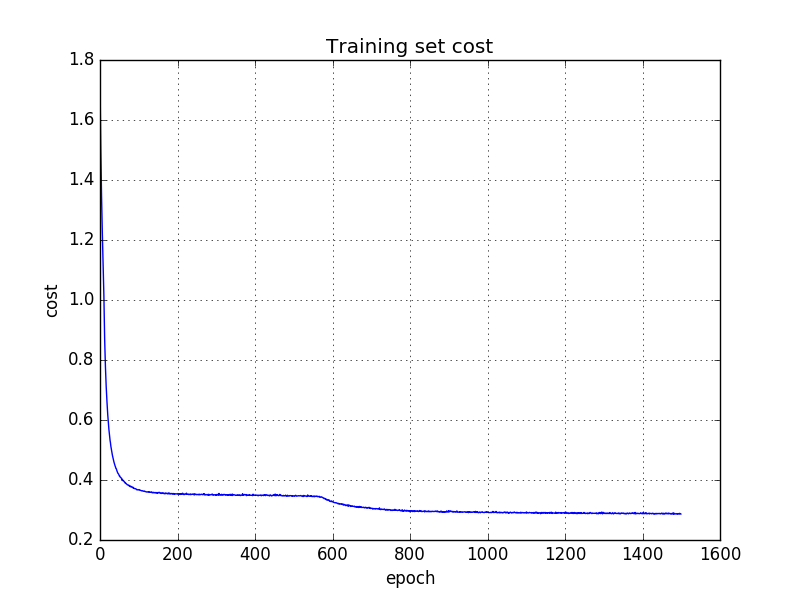

In [1]:
from IPython.display import Image
Image('images/nnf_c.png')

Confusion matrix: Training set

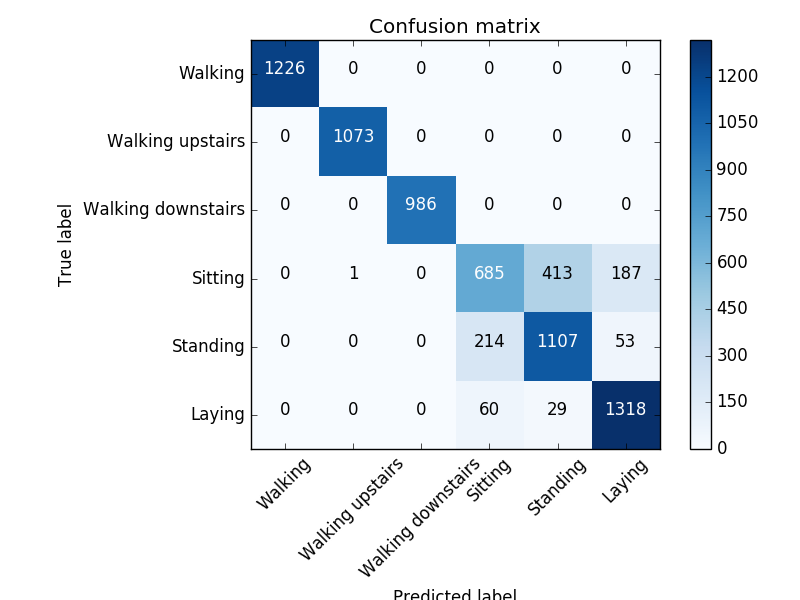

In [2]:
Image('images/nnf_train.png')

Confusion matrix: Test set

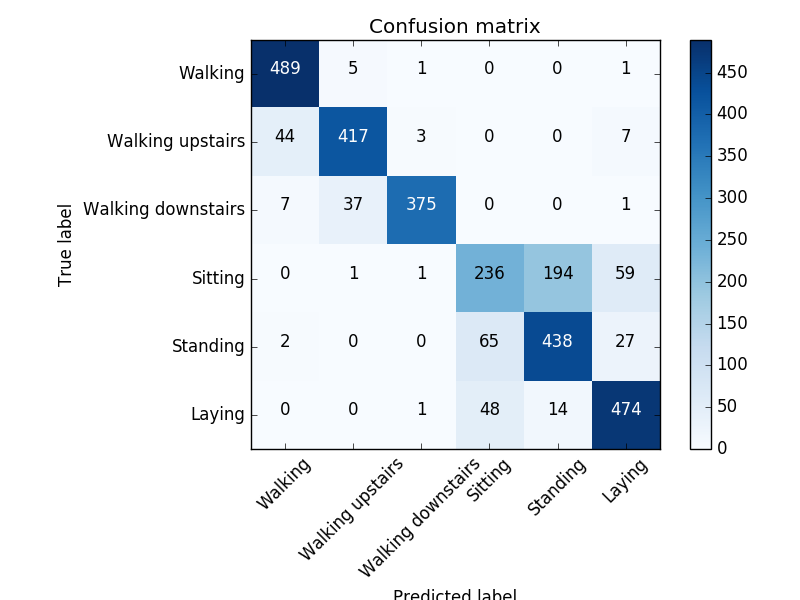

In [3]:
Image('images/nnf_test.png')